# **Proyek Klasifikasi Gambar: Brain Tumor MRI**

## Import Semua Packages/Library yang Digunakan

In [3]:
# Library yang sering digunakan
import matplotlib.pyplot as plt
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import seaborn as sns

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.16.2


# Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1) (1).json


{'kaggle (1) (1).json': b'{"username":"thecharolintan","key":"1b77ccf4432c0fd97eabe55e6fb86c9c"}'}

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training

In [4]:
train_dir = "Training"
test_dir = "Testing"

In [5]:
combined_dir = "Brain_Tumor_MRI_Dataset"
combined_dir

'Brain_Tumor_MRI_Dataset'

In [6]:
os.makedirs(combined_dir, exist_ok=True)

In [7]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

### Dataset Checking

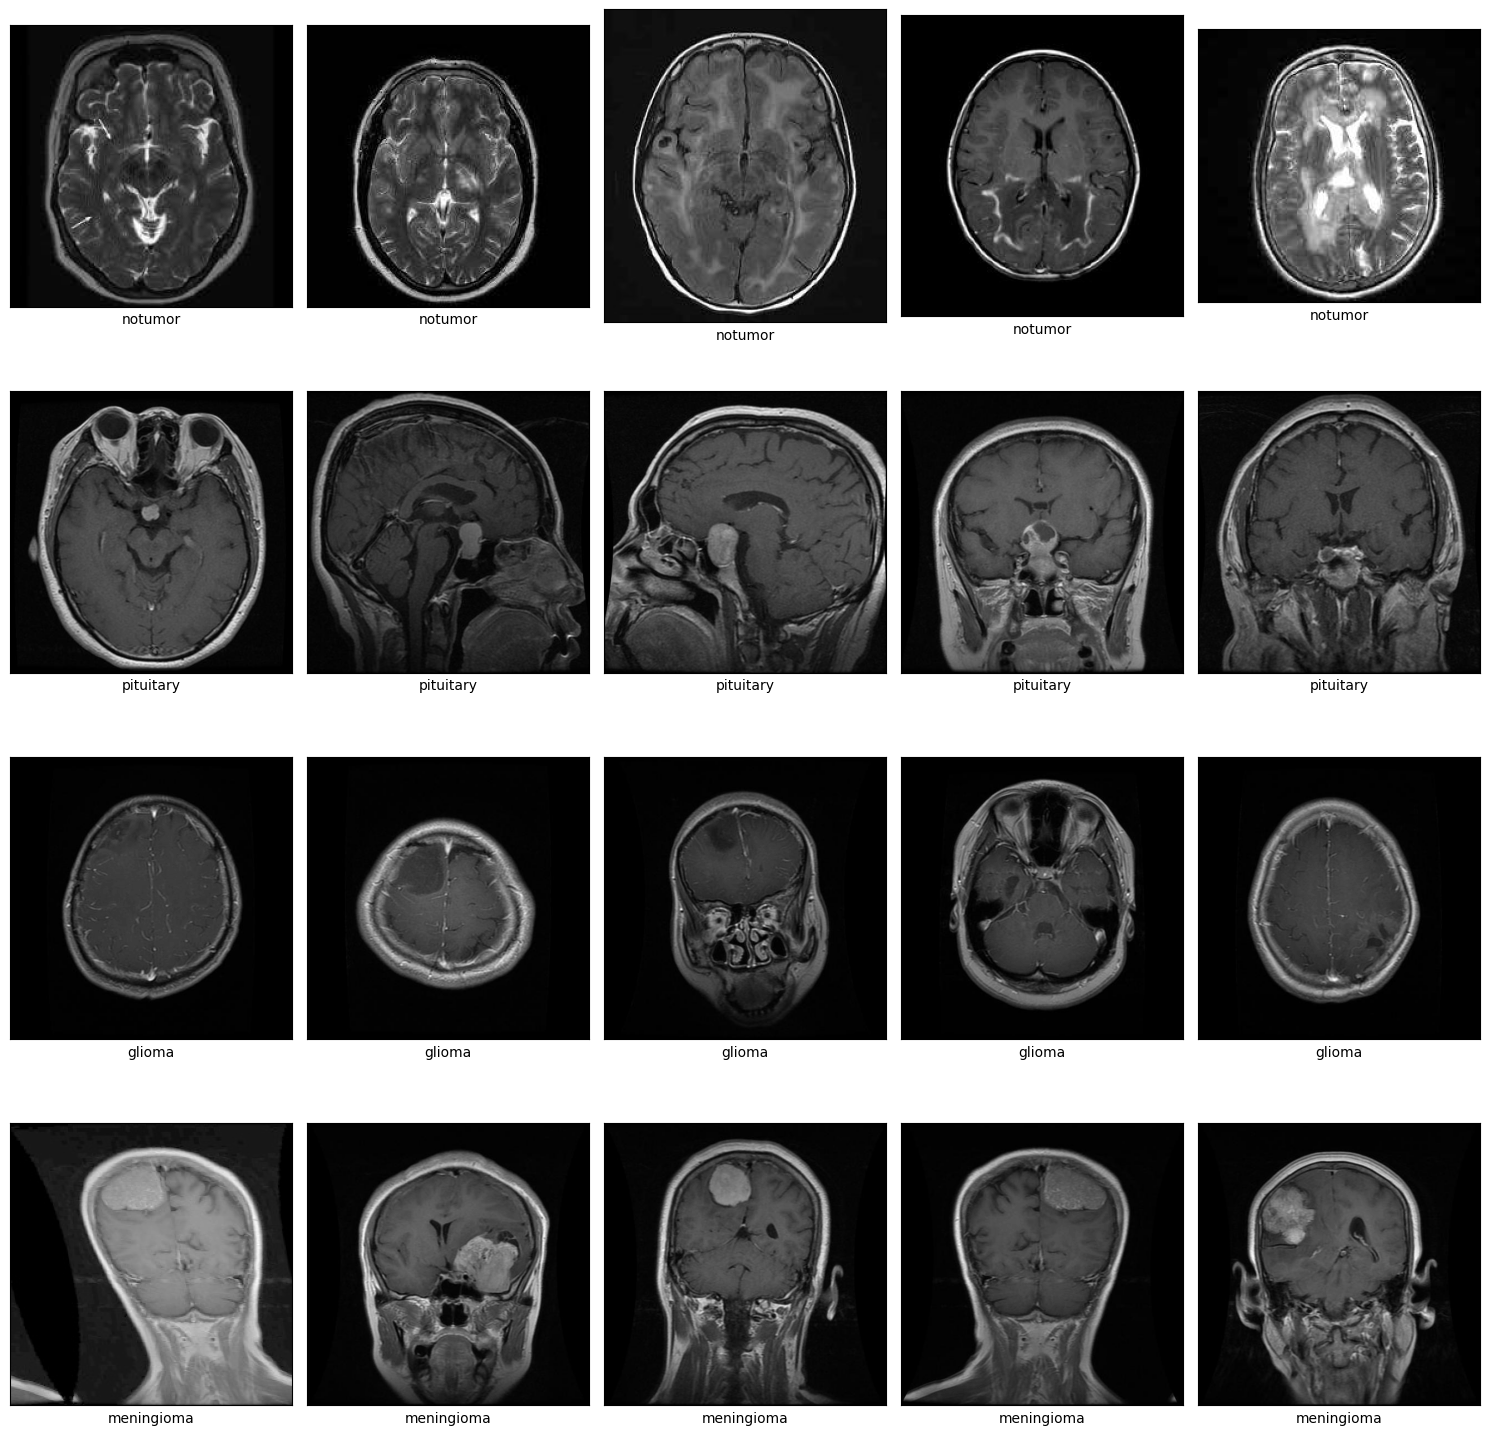

In [8]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
brain_image = {}

# Tentukan path sumber train
path = "Brain_Tumor_MRI_Dataset"
for i in os.listdir(path):
    brain_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas
fig, axs = plt.subplots(len(brain_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(brain_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

### Melihat Plot Distribusi Data

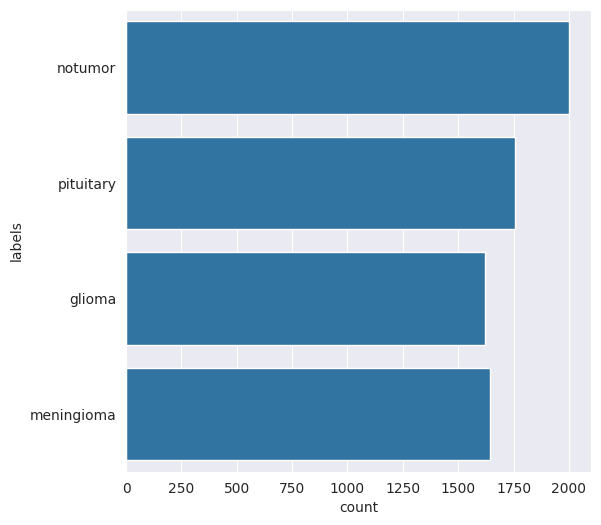

In [ ]:
lung_path = "Brain_Tumor_MRI_Dataset"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

Label = distribution_train['labels']
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)
plt.show()

# Data Augmentation

In [9]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [10]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Kelas yang akan diaugmentasi
classes_to_augment = ["glioma", "meningioma", "pituitary"]
augmented_path = "Brain_Tumor_MRI_Dataset"  # Path untuk gambar yang sudah diaugmentasi

for class_name in classes_to_augment:
    images_path = os.path.join(augmented_path, class_name)
    images = [os.path.join(images_path, img) for img in os.listdir(images_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Menghitung jumlah gambar yang perlu diaugmentasi
    images_to_generate = 2000 - len(images)
    i = 1
    while i <= images_to_generate:
        image_path = random.choice(images)
        try:
            original_image = io.imread(image_path)
            # Memastikan gambar dalam format uint8
            original_image = img_as_ubyte(original_image)
        except Exception as e:
            print(f"Could not read {image_path} with skimage: {e}, attempting to open with OpenCV")
            try:
                original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            except Exception as e2:
                print(f"Failed to open {image_path} with OpenCV as well: {e2}")
                continue

        try:
            transformed_image = original_image
            transformation_count = random.randint(1, len(transformations))

            for _ in range(transformation_count):
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)

            new_image_path = os.path.join(images_path, f"augmented_image_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
            i += 1
        except Exception as e:
            print(f"Failed to process {image_path}: {e}, skipping this image.")

print("Data augmentation completed!!!!!!!")

Data augmentation completed!!!!!!!


# Data Preprocessing

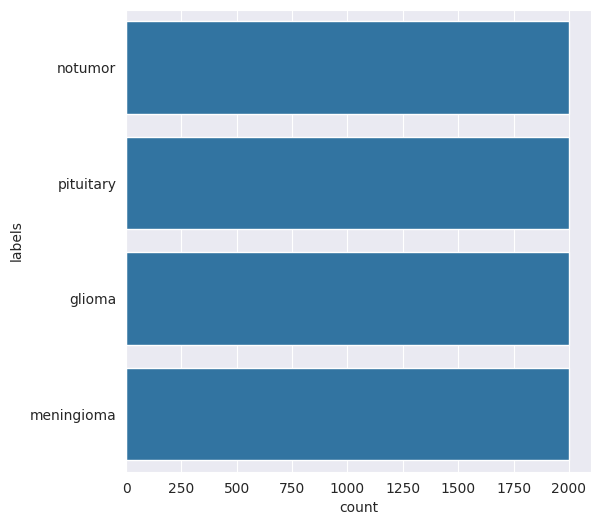

labels
notumor       2000
pituitary     2000
glioma        2000
meningioma    2000
Name: count, dtype: int64


In [11]:
# Mengecek distribusi setelah augmentasi
mypath = 'Brain_Tumor_MRI_Dataset/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        if name.endswith(('.png', '.jpg', '.jpeg')):
            full_path.append(os.path.join(path, name))
            labels.append(path.split('/')[-1])
            file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)
plt.show()

# Menghitung distribusi gambar di setiap kelas
distribution_counts = distribution_train['labels'].value_counts()

# Menampilkan distribusi dalam bentuk tabel
print(distribution_counts)

### Data Splitting

In [12]:
from sklearn.model_selection import train_test_split

mypath= 'Brain_Tumor_MRI_Dataset/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})
df.groupby(['labels']).size()

labels
glioma        2000
meningioma    2000
notumor       2000
pituitary     2000
dtype: int64

In [13]:
X = df['path']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)
len(X)

8000

In [14]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [15]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))

datasource_path = "Brain_Tumor_MRI_Dataset/"
dataset_path = "Dataset-Final/"


set    labels    
test   glioma         425
       meningioma     401
       notumor        403
       pituitary      371
train  glioma        1575
       meningioma    1599
       notumor       1597
       pituitary     1629
dtype: int64 


                                                   path      labels    set
3292  Brain_Tumor_MRI_Dataset/meningioma/Tr-me_0789.jpg  meningioma  train
6354      Brain_Tumor_MRI_Dataset/glioma/Te-gl_0110.jpg      glioma  train
4121      Brain_Tumor_MRI_Dataset/glioma/Tr-gl_0545.jpg      glioma  train
4939     Brain_Tumor_MRI_Dataset/notumor/Te-no_0255.jpg     notumor  train
464   Brain_Tumor_MRI_Dataset/meningioma/Tr-me_0743.jpg  meningioma  train


In [16]:
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if not os.path.exists(file_path):
            file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])

    if not os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])):
        os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

### Image Data Generator

In [17]:
TRAIN_DIR = "/content/Dataset-Final/train/"
TEST_DIR = "/content/Dataset-Final/test/"

train_notumor = os.path.join(TRAIN_DIR, 'notumor')
train_glioma = os.path.join(TRAIN_DIR, 'glioma')
train_meningioma = os.path.join(TRAIN_DIR, 'meningioma')
train_pituitary = os.path.join(TRAIN_DIR, 'pituitary')

test_notumor = os.path.join(TEST_DIR, 'notumor')
test_glioma = os.path.join(TEST_DIR, 'glioma')
test_meningioma = os.path.join(TEST_DIR, 'meningioma')
test_pituitary = os.path.join(TEST_DIR, 'pituitary')

In [18]:
def print_directory_contents(directory):
    if os.path.exists(directory):
        print(f"Total {os.path.basename(directory)}: ", len(os.listdir(directory)))
    else:
        print(f"Directory {directory} does not exist.")

print_directory_contents(train_notumor)
print_directory_contents(train_glioma)
print_directory_contents(train_meningioma)
print_directory_contents(train_pituitary)

print_directory_contents(test_notumor)
print_directory_contents(test_glioma)
print_directory_contents(test_meningioma)
print_directory_contents(test_pituitary)

Total notumor:  1597
Total glioma:  1575
Total meningioma:  1599
Total pituitary:  1629
Total notumor:  403
Total glioma:  425
Total meningioma:  401
Total pituitary:  371


In [19]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=1,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 6400 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


# Modelling

In [20]:
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(momentum=0.99),
    Dense(4, activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 8)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 37, 37, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21904)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,806,116 (10.70 MB)

 Trainable params: 2,805,860 (10.70 MB)

 Non-trainable params: 256 (1.00 KB)

In [21]:
# Kompilasi model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Penerapan Callbacks

In [22]:
class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.91 and logs.get('val_accuracy') > 0.905:
            self.model.stop_training = True
            print("\nAkurasi dari training set dan validation set telah terpenuhi > 91%!")

callbacks = StopTrainingCallback()

In [24]:
epochs = 20
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    batch_size=32,
    callbacks=[callbacks]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 104s 507ms/step - accuracy: 0.5325 - loss: 1.1370 - val_accuracy: 0.4144 - val_loss: 1.1975
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 450ms/step - accuracy: 0.7223 - loss: 0.6723 - val_accuracy: 0.5819 - val_loss: 0.9651
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 126s 631ms/step - accuracy: 0.7684 - loss: 0.5895 - val_accuracy: 0.6425 - val_loss: 0.7486
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 476ms/step - accuracy: 0.8033 - loss: 0.5054 - val_accuracy: 0.7600 - val_loss: 0.5482
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 92s 457ms/step - accuracy: 0.8306 - loss: 0.4493 - val_accuracy: 0.6950 - val_loss: 0.6973
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 144s 466ms/step - accuracy: 0.8639 - loss: 0.3585 - val_accuracy: 0.8388 - val_loss: 0.4597
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 457ms/step - accuracy: 0.8884 - loss: 0.3185 - val_accuracy: 0.8462 - val_loss: 0.4015
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 448ms/step - accuracy: 0.8995 - loss: 0.2768 -

# Evaluasi dan Visualisasi

### Plot Kurva

Text(0.5, 1.0, 'Kurva Akurasi')

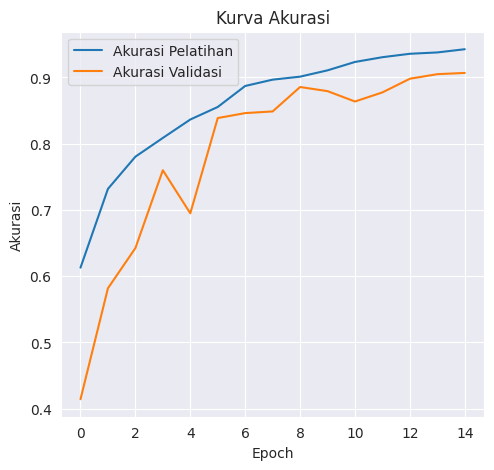

In [28]:
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.title('Kurva Akurasi')

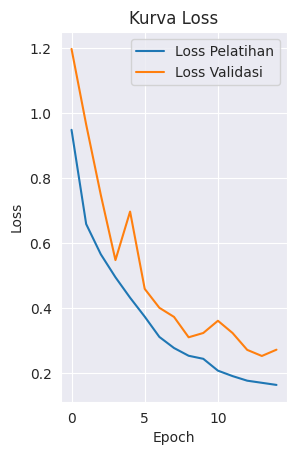

In [29]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Kurva Loss')

plt.show()

### Confusion Matrix



              precision    recall  f1-score   support

      glioma     0.8154    0.9459    0.8758       425
  meningioma     0.8969    0.8030    0.8474       401
     notumor     0.9923    0.9628    0.9773       403
   pituitary     0.9496    0.9137    0.9313       371

    accuracy                         0.9069      1600
   macro avg     0.9136    0.9064    0.9080      1600
weighted avg     0.9115    0.9069    0.9071      1600



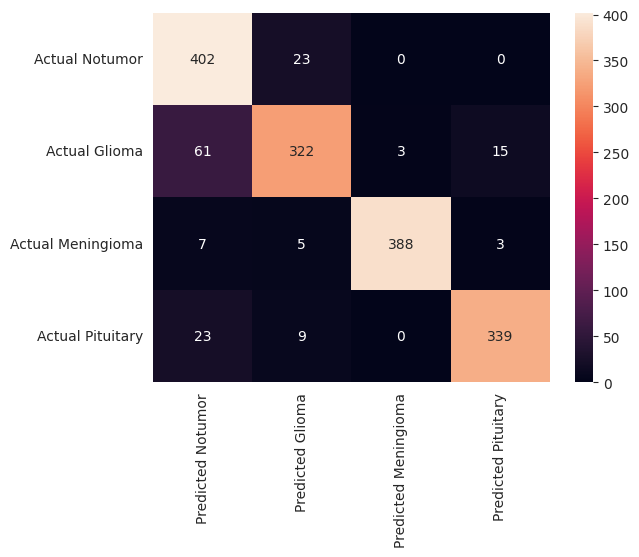

In [30]:
test_generator.reset()

preds = model.predict(test_generator, verbose=0)
preds = np.argmax(preds, axis=1)

# Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds, labels=[0, 1, 2, 3]),
                  index=["Actual Notumor", "Actual Glioma", "Actual Meningioma", "Actual Pituitary"],
                  columns=["Predicted Notumor", "Predicted Glioma", "Predicted Meningioma", "Predicted Pituitary"])
sns.heatmap(cm, annot=True, fmt="d")

# Classification Report
print("\n")
print(classification_report(test_generator.classes, preds, target_names=test_generator.class_indices.keys(), digits=4))

# Konversi Model

### SavedModel

In [31]:
import tensorflow as tf

save_path = 'saved_model/'
tf.saved_model.save(model, save_path)
print(f"Model saved to {save_path}")

Model saved to saved_model/


### TF-JS

In [37]:
model.save("model.h5")

In [1]:
# Pastikan tensorflowjs terinstal
!pip install tensorflowjs

# Konversi model H5 ke format TensorFlow.js
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-08-07 07:16:39.531180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 07:16:39.579879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 07:16:39.579950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 07:16:39.614208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 07:16:42.171717: W tensorflow/compiler/tf

### TF-Lite

In [35]:
import pathlib

# Tentukan direktori SavedModel
#export_dir = 'saved_model/'

# Simpan model ke dalam format SavedModel (jika belum dilakukan sebelumnya)
#tf.saved_model.save(model, export_dir)

# Konversi SavedModel menjadi TensorFlow Lite model
#converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
#tflite_model = converter.convert()

# Simpan model ke dalam file dengan nama 'model.tflite'
#tflite_model_file = pathlib.Path('model.tflite')
#tflite_model_file.write_bytes(tflite_model)
#print("Model converted to TensorFlow Lite format and saved to 'model.tflite'")

import tensorflow as tf
model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

Saved artifact at '/tmp/tmp7t0eh7ri'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132706014352784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132706015185024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132706266788640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132706266786000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132706012300560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132706012305488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132706012337904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132706012335088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132706012333680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132706012335440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132706012342656

11225856

In [5]:
def recreate_labels():
    labels = [folder for folder in os.listdir('Brain_Tumor_MRI_Dataset') if not folder.startswith('.')]

    with open('labels.txt', 'w') as file:
        for label in labels:
            file.write(label)
            file.write('\n')

recreate_labels()

# Inference/Testing

Saving Screenshot 2024-08-07 000252.png to Screenshot 2024-08-07 000252.png


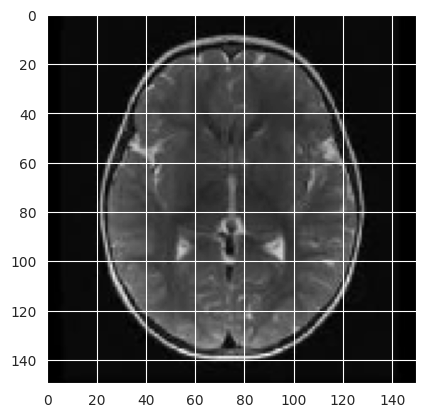

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Filename: Screenshot 2024-08-07 000252.png
Predicted Class: notumor


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  # Path ke gambar yang diunggah
  path = fn
  img = image.load_img(path, target_size=(150, 150), color_mode='grayscale')
  imgplot = plt.imshow(img, cmap='gray')
  plt.show()

  # Mengubah gambar menjadi array dan menormalisasi
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0

  # Melakukan prediksi
  classes = model.predict(x)

  # Menampilkan hasil prediksi
  class_indices = {v: k for k, v in train_generator.class_indices.items()}
  predicted_class = np.argmax(classes, axis=1)[0]
  predicted_class_name = class_indices[predicted_class]

  print(f"Filename: {fn}")
  print(f"Predicted Class: {predicted_class_name}")
